# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2022
## Домашнее задание 3. Сравнение оценок и эффективные оценки

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде, 
* собственно кодом, 
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача в этом задании оценивается в **15 баллов**.

## Пожалуйста, не переименовывайте этот ноутбук

In [1]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid", font_scale=1.4)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задача 1

Сгенерируйте выборку из трех распределений: нормального, Лапласа и Коши размера `N=500`.

Далее для всех графиков в этом задании используйте обозначенные цвета для каждого из распределений (даже если графики будут на разных осях). То есть если график касается нормального распределения то рисуйте его синим цветом.

In [2]:
color_for_normal=sns.color_palette("colorblind")[0]
color_for_laplace=sns.color_palette("colorblind")[1]
color_for_cauchy=sns.color_palette("colorblind")[2]

N=500

norm_distr = sps.norm()
laplacian_distr = sps.laplace()
cauchy_distr = sps.cauchy()
np.random.seed(2020)

norm_sample = norm_distr.rvs(size=N)
laplace_sample = laplacian_distr.rvs(size=N)
cauchy_sample = cauchy_distr.rvs(size=N)

Постройте график плотности распределения для всех трех распределений на одних осях.

In [3]:
ppf_low = min(norm_distr.ppf(0.01), laplacian_distr.ppf(0.01), cauchy_distr.ppf(0.01))
ppf_high = max(norm_distr.ppf(0.99), laplacian_distr.ppf(0.99), cauchy_distr.ppf(0.99))

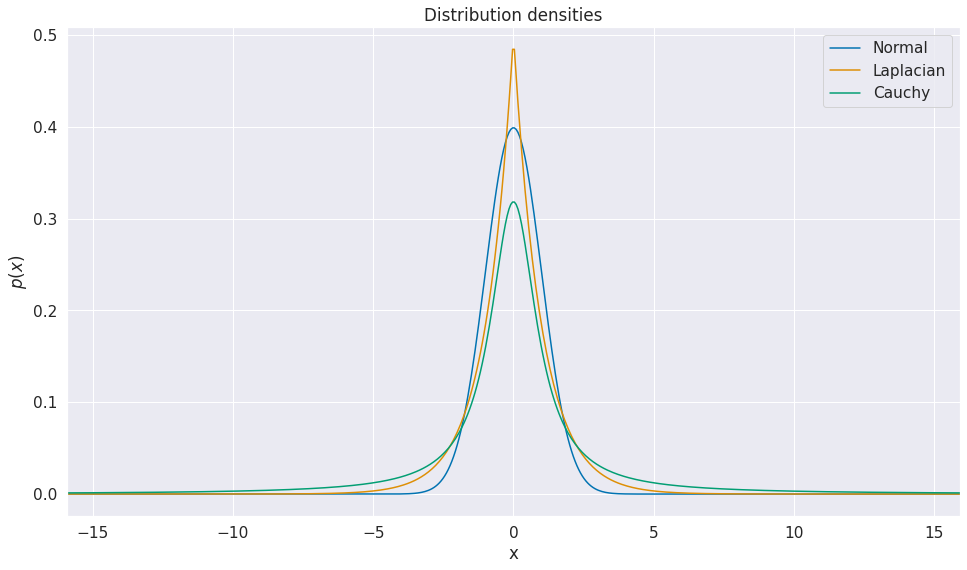

In [4]:
x = np.linspace(ppf_low, ppf_high, 1000)

plt.figure(figsize=(16, 9))
plt.title('Distribution densities')
plt.plot(x, norm_distr.pdf(x), color=color_for_normal, label='Normal')
plt.plot(x, laplacian_distr.pdf(x), color=color_for_laplace, label='Laplacian')
plt.plot(x, cauchy_distr.pdf(x), color=color_for_cauchy, label='Cauchy')
plt.xlim(ppf_low / 2, ppf_high / 2)
plt.legend()
plt.xlabel('x')
plt.ylabel(r"$p(x)$")
plt.show()

Подумайте для каких распределений сложнее найти значение математического ожидания по выборке? Почему?

**Ответ:**
Для распределений с тяжелыми хвостами сложнее найти математическое ожидание по выборке, так как больше вероятность получить в выборке "аномально" большие или маленькие значения, смещающие наши оценки

Часто, в реальной жизни, мы сталкиваемся с данными в которых есть выбросы возникшие, например, из-за опечаток. Пусть в выборке содержится 99 точек на интервале $[0;1]$ и один элемент равный 300. Тогда среднее значение нашей выборки будет не меньше трех. Ясно, что так дело не пойдет, что же делать?

Можно использовать медиану или **усеченное среднее**.

**Усеченное среднее порядка $\alpha$** это среднее составленное из выборки от которой отрезаны $\alpha$ и $1 - \alpha$ квантили. Как ее получить?


1.   Отсортировать выборку
2.   Отрезать первые и последние ($\alpha \cdot \text{размер выборки}$) элементов выборки
3.   Посчитать среднее полученной выборки

Напишите функцию для подсчета этой статистики.

In [5]:
import math

def truncated_mean(sample, alpha=0.35):
  lower_bound = math.floor(alpha * len(sample))
  upper_bound = len(sample) - lower_bound
  return np.sort(sample)[lower_bound : upper_bound].mean()

**Теорема**
Пусть распределение симметрично относительно нуля и имеет одну моду в нуле, тогда асимптотическая дисперсия усеченного среднего порядка $\alpha$ может быть выражена по формуле:
$$
\sigma^2(\alpha) = 2\cdot\frac{\int_0^{u_{1 - \alpha}} x^2 dF(x) + \alpha\cdot(u_{1 - \alpha})^2}{(1 - 2\alpha)^2},
$$

где $u_\alpha$ – квантиль порядка $\alpha$.

Напишите функцию, которая это делает.

*Подсказка.* Для численного интегрирования используйте функцию `quad` из модуля `scipy.integrate`

In [6]:
from scipy.integrate import quad

def asymp_var(distr, alpha):
  quantile = distr.ppf(1 - alpha)
  func = lambda x : (x ** 2) * distr.pdf(x)
  quad_vectorized = np.vectorize(quad)
  y, err = 2 * (quad_vectorized(func, a=0, b=quantile) + alpha * (quantile ** 2)) / (1 - 2 * alpha) ** 2
  return y

Постройте графики для асимптотической дисперсии в зависимости от $\alpha$ для всех трех распределений на назных осях (используйте `plt.subplots(1, 3, figsize=(21,7))`). **Не забудьте про цвета**. Для заголовка графика используйте `ax[i].set_title`, для заголовка всей картинки используйте `fig.suptitle`.

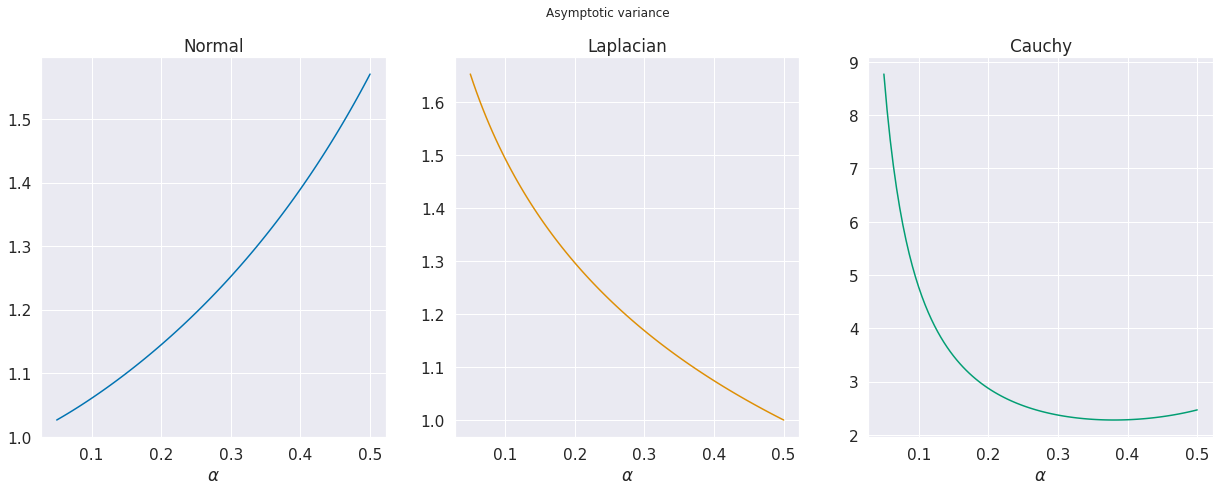

In [7]:
alpha_grid = np.linspace(0.05, 0.49999, 100)

fig, ax = plt.subplots(1, 3, figsize=(21,7))

ax[0].plot(alpha_grid, asymp_var(norm_distr, alpha_grid), color=color_for_normal)
ax[0].set_title('Normal')
ax[0].set_xlabel(r'$\alpha$')

ax[1].plot(alpha_grid, asymp_var(laplacian_distr, alpha_grid), color=color_for_laplace)
ax[1].set_title('Laplacian')
ax[1].set_xlabel(r'$\alpha$')

ax[2].plot(alpha_grid, asymp_var(cauchy_distr, alpha_grid), color=color_for_cauchy)
ax[2].set_title('Cauchy')
ax[2].set_xlabel(r'$\alpha$')

fig.suptitle('Asymptotic variance')
plt.show()

Как можно интепретировать такой график? Напишите развернутый вывод.

*Подсказка.* Подумайте, какой известной оценке соответствует усеченное среднее порядка 0.5? А порядка 0?

**Ответ:**
При $\alpha = 0.5$ мы получаем медиану, а при $\alpha = 0$  обычное среднее. Получается, что для распределений с тяжелыми хвостами мерой центральной тенденции лучше брать медиану, чем среднее.

Для каждого распределение на отдельном графике постройте значение трех оценок: среднего, медианы и усученного 😆 среднего порядка $0.35$. Для усеченного среднего проведите линию пунктиром (`fmt="--"`), для медианы точечками (`fmt=":"`). **Не забудьте про цвета**. То есть цвета на одном графике одинаковые, разные оценки отличает только формат линии.

**Ниже посчитайте все оценки необходимые для всех распределений**

In [8]:
def cum_median(sample):
  return np.array([np.median(sample[:i]) for i in range(1, len(sample) + 1)])

def cum_trunc_mean(sample):
  return np.array([truncated_mean(sample[:i]) for i in range(1, len(sample) + 1)])

def get_estimates(sample):
  mean = np.cumsum(sample) / np.arange(1, N + 1)
  med = cum_median(sample)
  trunc_mean = cum_trunc_mean(sample)
  return mean, med, trunc_mean

def make_plot(distr_type, sample, ymin, ymax):
  mean, med, trunc_mean = get_estimates(sample)
  if distr_type == 'normal':
    color = color_for_normal
  elif distr_type == 'laplace':
    color = color_for_laplace
  elif distr_type == 'cauchy':
    color = color_for_cauchy
  
  plt.figure(figsize=(21, 12))
  plt.title(f"Estimates for {distr_type} distribution$")
  plt.plot(np.arange(N), mean, color=color, label=r'Mean')
  plt.plot(np.arange(N), med, ":", color=color, label=r'Median')
  plt.plot(np.arange(N), trunc_mean, "--", color=color, label=r'Truncated mean 0.35')
  plt.legend()
  plt.ylim(ymin, ymax)
  plt.xlabel('N')
  plt.ylabel(r'$\theta$')
  plt.show()

**Нормальное распределение**

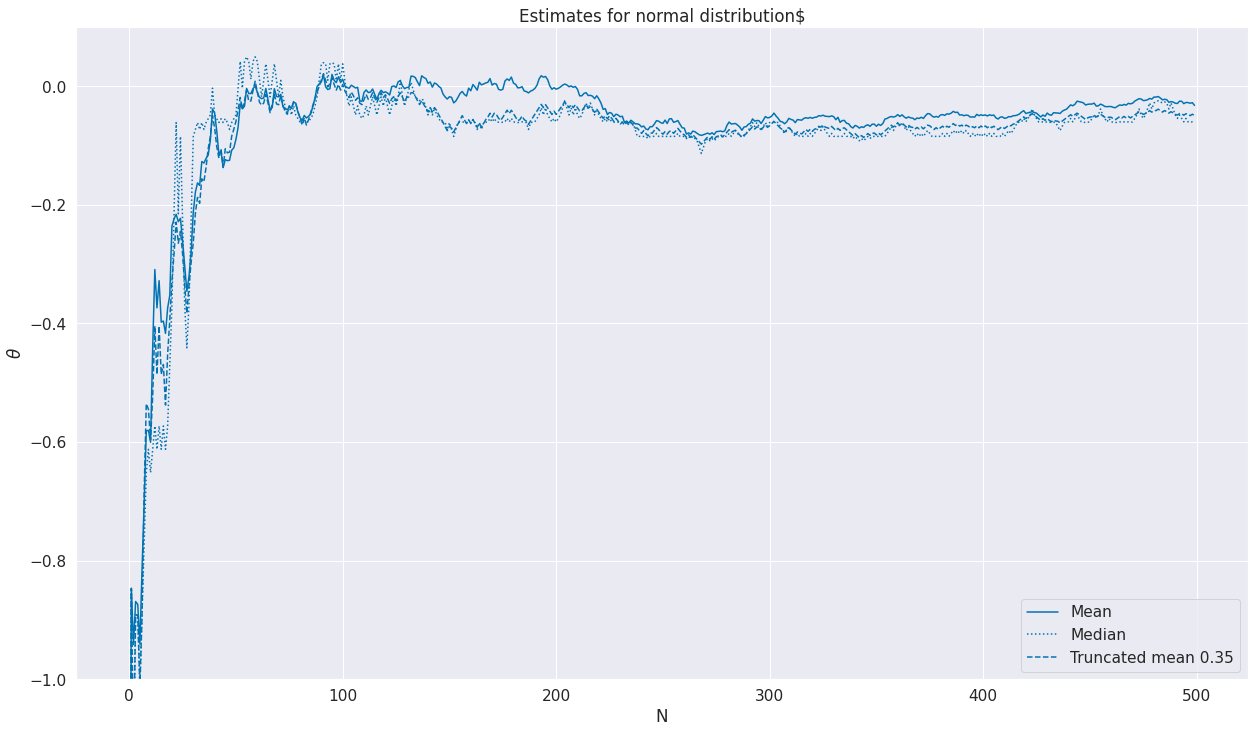

In [9]:
make_plot('normal', norm_sample, -1, 0.1)

**Распределение Лапласа**

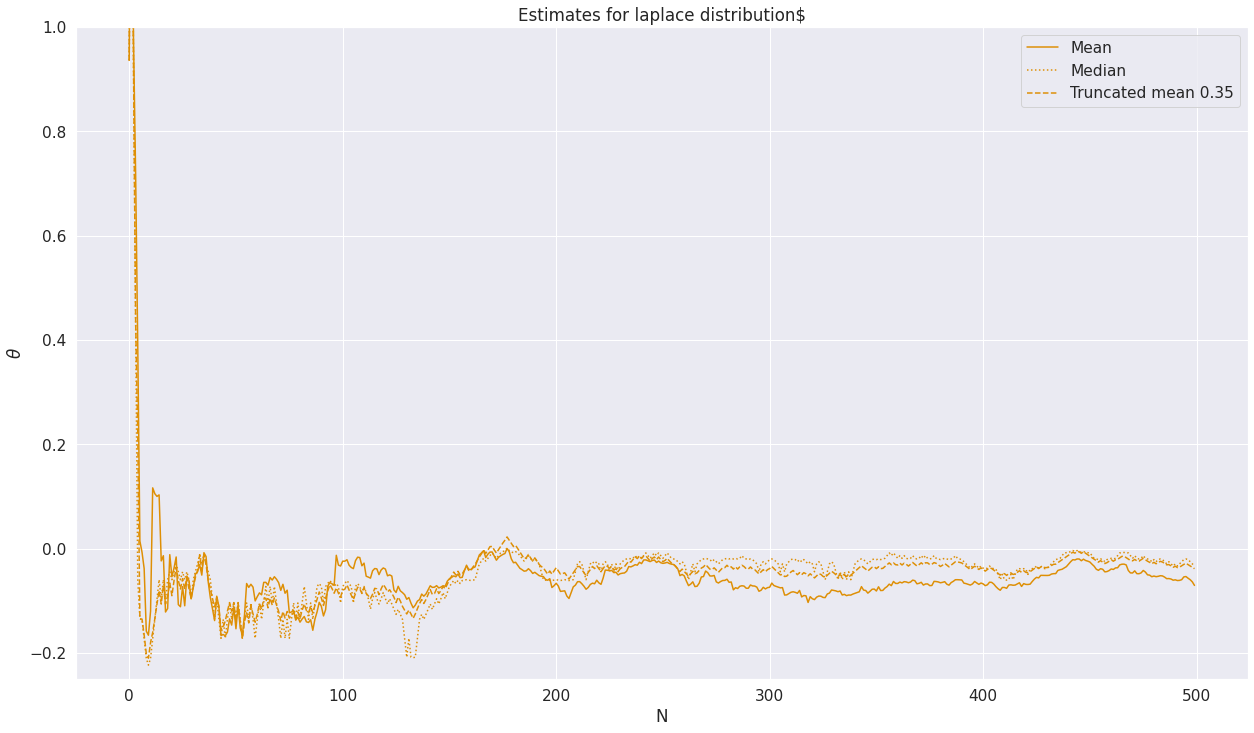

In [10]:
make_plot('laplace', laplace_sample, -0.25, 1)

**Распределение Коши**

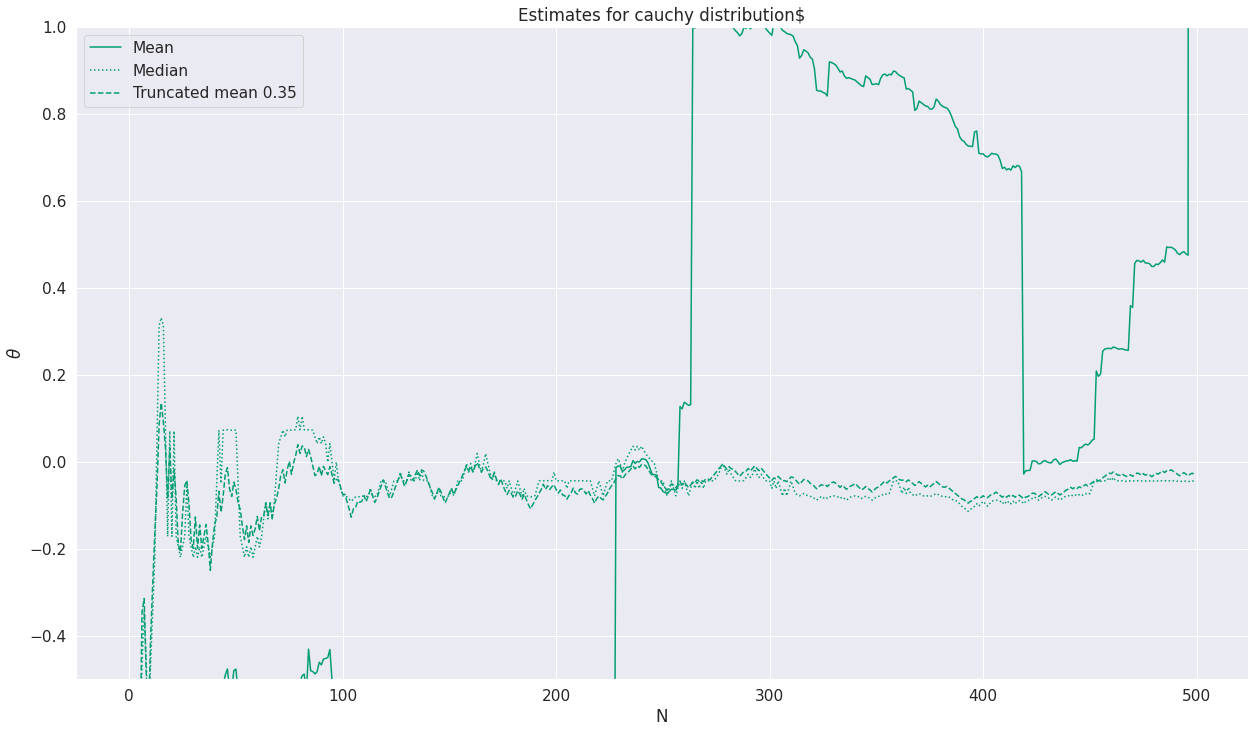

In [11]:
make_plot('cauchy', cauchy_sample, -0.5, 1)

Как эти три графика соотносятся с графиками асимптотической дисперсии усеченного среднего для всех этих распределений? Сделайте вывод.

**Вывод:**

# Задача 2

## Wine dataset

Давайте загрузим и проанализируем датасет, состоящий из различных показателей для красного вина и оценок сомелье. 

In [12]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1LsNeROfnVQb2ksdtwZvxrZREdy_Z-jta

Downloading...
From: https://drive.google.com/uc?id=1LsNeROfnVQb2ksdtwZvxrZREdy_Z-jta
To: /content/winequality-red.csv
100% 101k/101k [00:00<00:00, 58.1MB/s]


In [13]:
import pandas as pd

In [14]:
data = pd.read_csv("winequality-red.csv")

In [15]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Поделите вина на три категории по содержанию алкоголя. Добавьте колонку `"category"` со значениями `"low alcohol"`, `"medium alcohol"`, `"high alcohol"` для относительного объемного содержания алкоголя `x<=10`, `10 < x <= 12`, `x > 12` соответственно.

In [16]:
def alco_categorize(row):
    if row['alcohol'] <= 10:
      return 'low alcohol'
    elif 10 < row['alcohol'] <= 12:
      return 'medium alcohol'
    elif row['alcohol'] > 12:
      return 'high alcohol'

data['category'] = data.apply(lambda row : alco_categorize(row), axis=1)

Для каждой категории посчитайте среднее и медиану содержания остаточного сахара (`"residual sugar"`). Сделайте pandas.DataFrame с индексами в виде категории содержания алкоголя и колнками в виде среднего и медианы.

In [17]:
data.groupby('category').aggregate([np.mean, np.median])['residual sugar']

,mean,median
category,,
high alcohol,2.760993,2.3
low alcohol,2.445984,2.1
medium alcohol,2.592264,2.2


Что можно сказать о распределении сахара по этим категориям? О распределении остаточного сахара в целом?

**Ответ:**
Чем выше содержание остаточного сахара, тем крепче вино. Для каждой категории есть "аномально" большие значения остаточного сахара, так как среднее больше медианы.


*Ну а вообще говоря, содержание остаточного сахара не обязательно пропорционально содержанию алкоголя. Так например сухие вина в среднем крепче, чем полусухие, хоть остаточного сахара в них и меньше([ссылка](https://vinestore.ru/articles/sahar-v-vine/))*

Постройте `boxplot` для остаточного сахара по категориям, полученным ранее на основании доли алкоголя.

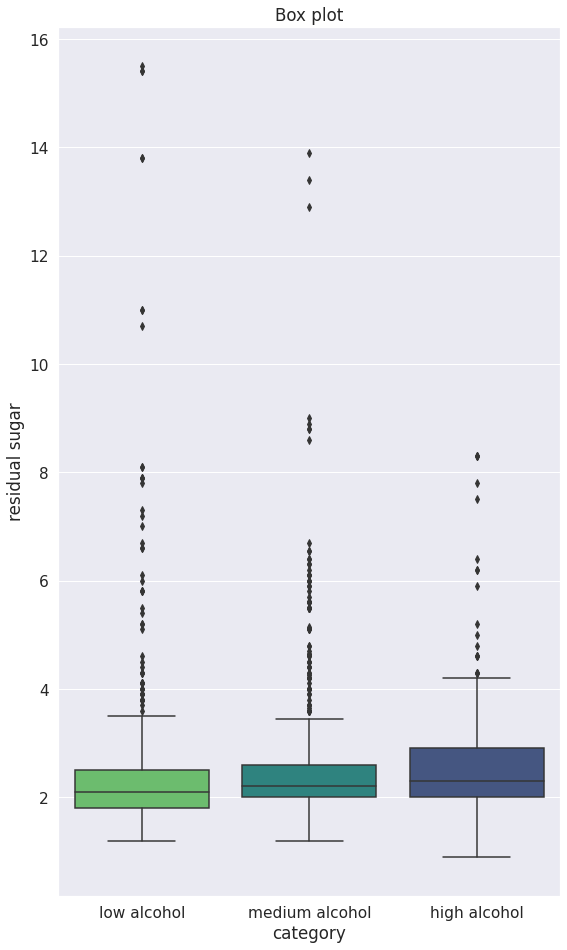

In [18]:
palette = sns.color_palette("viridis", n_colors=3)[::-1]

plt.figure(figsize=(9, 16))
plt.title('Box plot')
with sns.axes_style("whitegrid"):
    sns.boxplot(x=data['category'], y=data['residual sugar'], palette=palette)

Как соотносятся оценки из предыдущего пункта и график сверху? Что лучше использовать для оценивания содержания сахара: медиану или среднее? Почему?

**Ответ:**
График подтверждает наличие значений, которые больше, чем значения статистически значимой выборки. Так как среднее менее устойчиво к выбросам, то для оценивания лучше использовать медиану.

Постройте один `scatterplot` (используйте `seaborn`) для очень хороших и очень плохих вин (`quality == 3`, `quality == 8`) в зависимости от содержания алкоголя (`alcohol` **не** из предыдущего пункта, а из колонки исходного датасета) и от количества лимонной кислоты (`citric acid`). Используйте `palette=[palette[0]]+[palette[-1]]`.

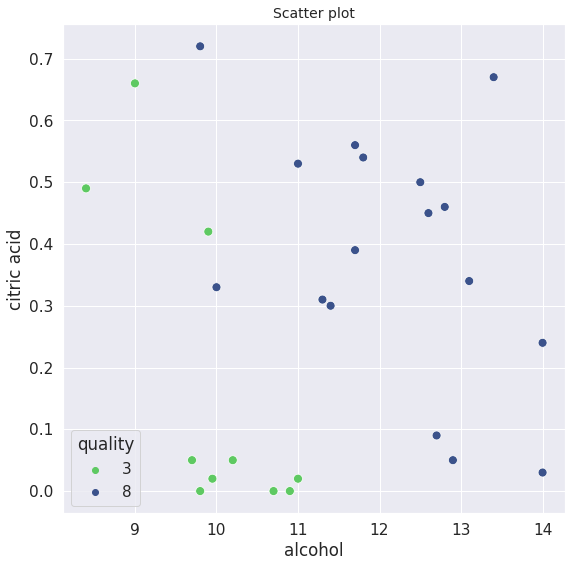

In [19]:
plt.figure(figsize=(9, 9))
plt.title('Scatter plot', fontsize=14)
sns.scatterplot(
    data=data[(data['quality'] == 3) | (data['quality'] == 8)], 
    x='alcohol', 
    y='citric acid', 
    hue='quality', 
    palette=[palette[0]]+[palette[-1]],
    s=80
)
plt.show()

Найдите ОМП для двух этих распределений в предположении, что обе выбоки из многомерного нормального распределения. Не мудрите, $\mu$ и $\Sigma$ получаются в одну команду через `numpy`. Далее получите плотности для сетки `X`, `Y`. Используйте `sps.multivariate_normal`.

In [20]:
sample_good = data[data['quality'] == 3][['alcohol', 'citric acid']]
sample_bad = data[data['quality'] == 8][['alcohol', 'citric acid']]

mean_good = sample_good.mean()
var_good = sample_good.corr()

mean_bad = sample_bad.mean()
var_bad = sample_bad.corr()

rv_good = sps.multivariate_normal(mean_good, var_good)
rv_bad = sps.multivariate_normal(mean_bad, var_bad)

Нарисуйте график плотности с линиями контура и нанесите точки выборки. Используйте зеленый цвет для вина плохого качества (`get_density_cmap("Greens")` и `"g"` для точек) и синий для вина хорошего качества (`get_density_cmap("Blues")` и `"b"`). Используйте функции `plt.pcolormesh`, `plt.clabel` и `plt.scatter`. Не забудьте про `plt.xlabel`, `plt.ylabel` и `plt.legend`.

In [21]:
from matplotlib.colors import ListedColormap

def get_density_cmap(name):
    cmap =  plt.get_cmap(name)
    cmap_col = cmap(np.arange(cmap.N))
    cmap_col[:, -1] = np.linspace(0, 1, cmap.N)**2
    return ListedColormap(cmap_col)

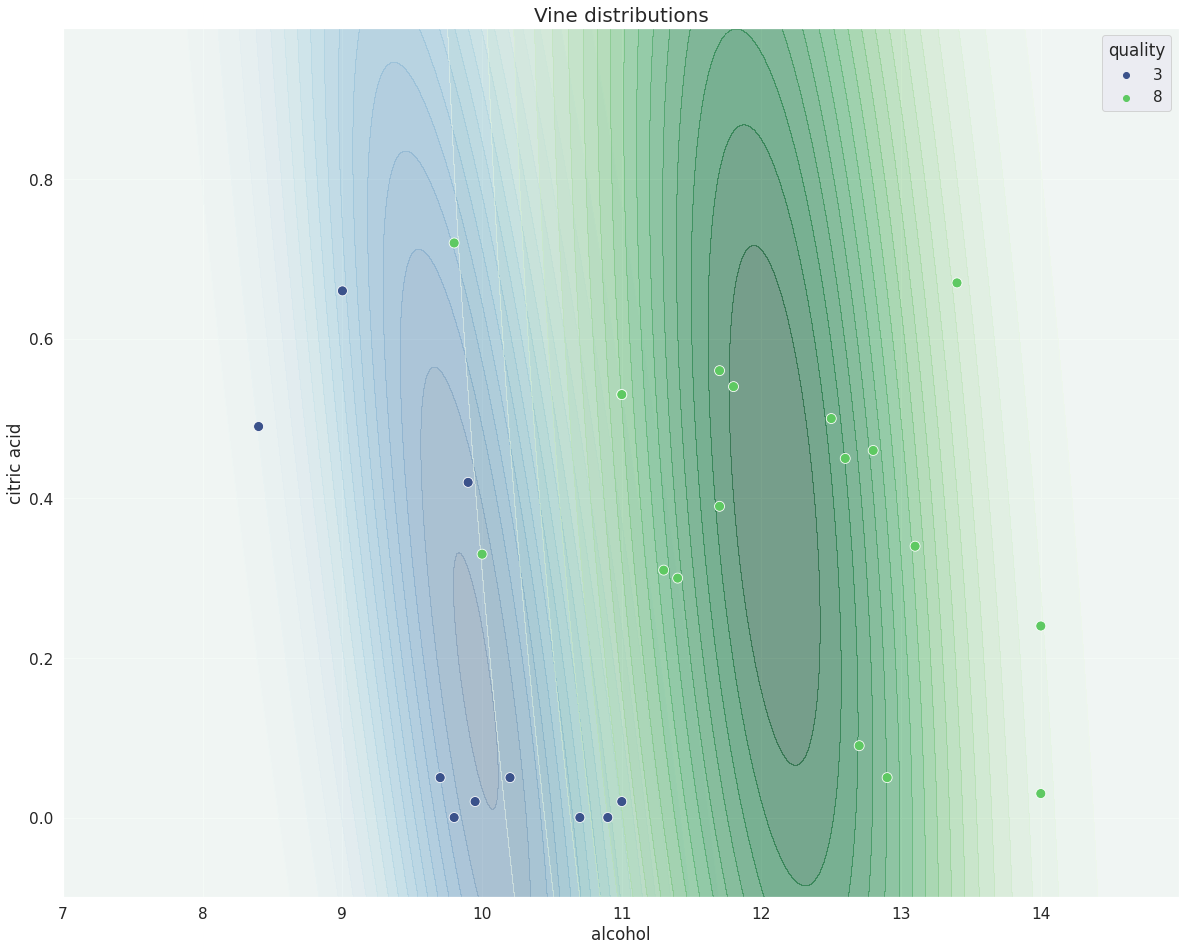

In [22]:
x, y = np.mgrid[7:15:.01, -0.1:1:.01]
pos = np.dstack((x, y))
plt.figure(figsize=(20, 16))
plt.contourf(x, y, rv_good.pdf(pos), alpha=0.6, levels=20, cmap=get_density_cmap('Blues'))
plt.contourf(x, y, rv_bad.pdf(pos), alpha=0.5, levels=20, cmap=get_density_cmap('Greens'))
sns.scatterplot(
    data=data[(data['quality'] == 3) | (data['quality'] == 8)], 
    x='alcohol', 
    y='citric acid', 
    hue='quality', 
    palette=[palette[-1]]+[palette[0]],
    s=100
)
plt.title(r'Vine distributions', fontsize=20)
plt.show()

Что можно сказать о вине, которому сомелье дали наивысший балл по сравнению с вином, которому дали наименьший балл, основываясь на график выше?

**Ответ:**
Хорошие оценки чаще ставят винам с более низким содержанием алкоголя и лимонной кислоты

# Задача 3

Рассмотрим $X_1, ..., X_n \sim Bern(\theta)$. По сетке значений $ \theta \in [0, 1]$ с шагом 0.01 постройте график зависимости нижней оценки дисперсии произвольной несмещенной оценки из неравенства Рао-Крамера от $\theta$. 

In [23]:
theta = np.linspace(0, 1, 101)

Неравенство Рао-Крамера:
$$D_{\theta}\theta^* \geqslant \frac{(\tau'(\theta))^2}{n\cdot i(\theta)}$$

Из разобранной в методичке задачи известно, что для бернулевского распределения информация Фишера одного наблюдения: 
$$i(\theta) = \frac{1}{\theta(1 - \theta)}$$

В нашем случае $\tau(\theta) = \theta$ и неравенство Рао-Крамера принимает вид:
$$D_{\theta}\theta^* \geqslant \frac{\theta(1 - \theta)}{n}.$$

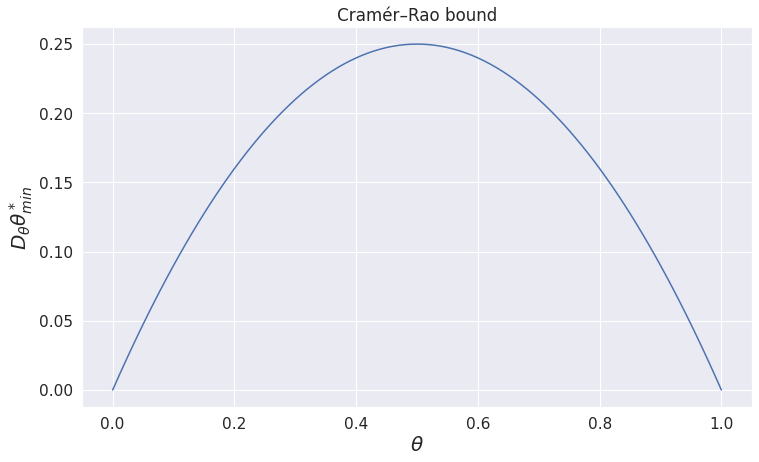

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(theta, -theta * (theta - 1))
plt.title('Cramér–Rao bound')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel(r'$D_{\theta}\theta^*_{min}$', fontsize=20)
plt.show()

Какой можно сделать вывод (напишите в комментариях)?

**Вывод**
Нижняя граница дисперсии оценки минимальна при больших и малых $\theta$ и максимальна при $\theta=0.5$

 Для каждого значения $\theta$ (для той же сетки) сгенерируйте выборку размера $n=1000$ для параметра $\theta$, посчитайте эффективную оценку $\theta$ и бутстрепную оценку дисперсии (количество бутстрепных выборок равно $1000$) этой эффективной оценки $\theta$.

Из методички эффективная оценка $\theta^* = \overline{X}$

In [25]:
def bootstrap(sample, k):
  subsamples = np.random.choice(sample[:k], (k, k))
  thetas = np.mean(subsamples, axis = 1)
  mean = thetas.mean()
  var = thetas.var(ddof=N-1)
  return mean, var
  

In [26]:
N = int(1e3)
bern_samples = np.array([sps.bernoulli(t).rvs(size=N) for t in theta])
means = np.array([])
vars = np.array([])
for sample in bern_samples:
  mean, var = bootstrap(sample, N)
  means = np.append(means, mean)
  vars = np.append(vars, var)

 Нарисуйте график зависимости полученных бутстрепных оценок от $\theta$.

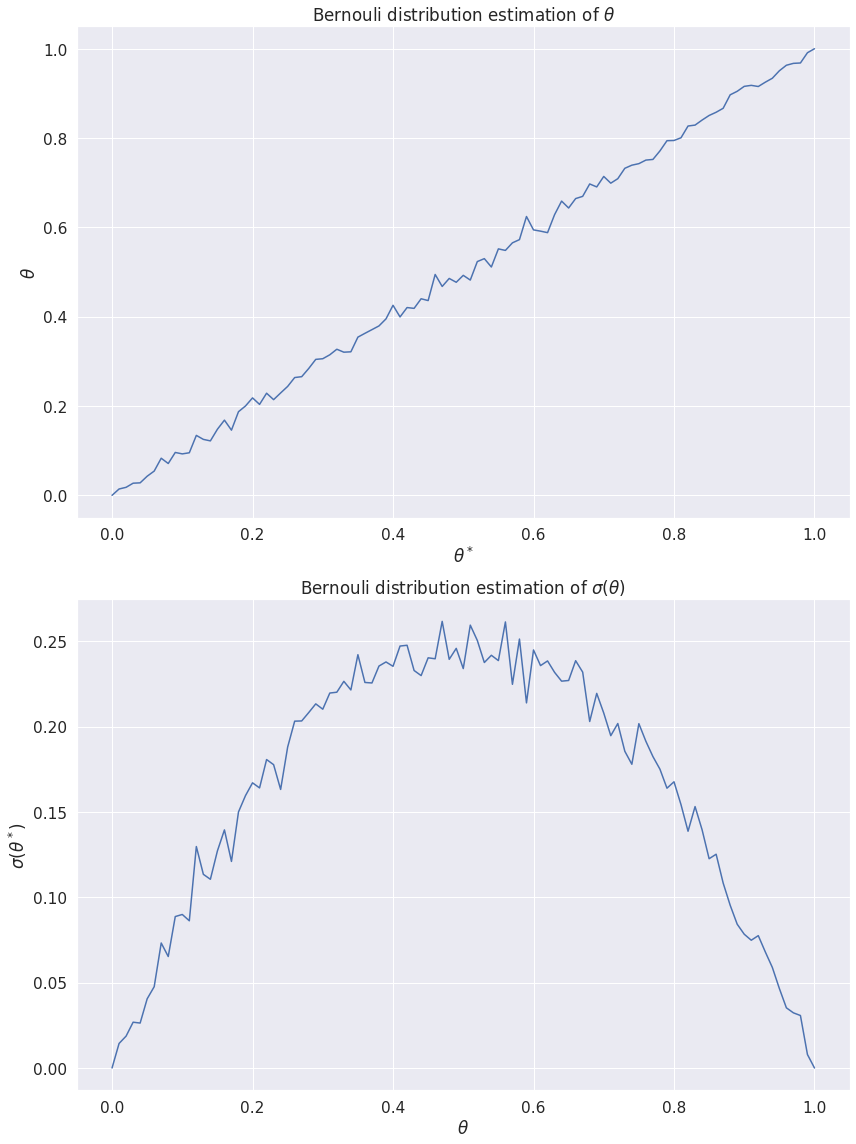

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), tight_layout=True)
ax1.plot(theta, means)
ax2.plot(theta, vars)
ax1.set_title(r'Bernouli distribution estimation of $\theta$')
ax1.set_ylabel(r'$\theta$')
ax1.set_xlabel(r'$\theta^*$')
ax2.set_title(r'Bernouli distribution estimation of $\sigma(\theta)$')
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\sigma(\theta^*)$')
plt.show()

**Вывод:**
Заметим, что график для теоретической зависимости нижней оценки дисперсии из неравенства Рао-Крамера хорошо совпадает с графиком для бутстрепных оценок дисперсии из практического эксперимента.